### Connect to database

In [72]:
import mysql.connector

# connect to remote db
cnx = mysql.connector.connect(user="emlyon1",
                              password="student1",
                              host="analyst-toolbelt.cn119w37trlg.eu-west-1.rds.amazonaws.com",
                              database="B2B")
cursor = cnx.cursor()

#get all companies

companies_query = ("SELECT DISTINCT searchterm from tweet")
cursor.execute(companies_query)
companies = list(cursor)


# keep only the company names
companies = list(map(lambda x: x[0], companies))

#get tweets for each company

def get_tweets(company_name):
    query = ("SELECT DISTINCT text FROM tweet WHERE searchterm = '" + company_name + "' AND text IS NOT NULL")
    cursor.execute(query)
    tweets = list(cursor)
    texts = list(map(lambda x: x[0], tweets))
    return texts


### create a naive workcloud using wordcloud lib

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_a_worldcloud(tweets):
    # get one single text
    text = " ".join(tweets)
    # create a wordcloud 
    wordcloud = WordCloud(width=800, height=400).generate(text)
    
    # matplotlib image
    plt.figure(figsize=(30, 30))
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

Now we have to write functions to build a better one.
* first we have to keep only the english tweets
* then remove urls
* then remove words beginning with @ and #

### language detection

In [74]:
from langdetect import detect
import collections

def get_the_most_spoken_language(tweets):
    # detect language
    langs = []
    for text in tweets:
        try:
            langs.append(detect(text))
        except :
            tweets.remove(text)
    

    # sort by frequency
    dic = collections.Counter(langs).most_common()
    # print results
    
    for i in range(10):
        print ("language: {:s},\tnumber of tweets: {:d},\t percentage: {:.0f}%".format(dic[i][0], dic[i][1], dic[i][1] / len(langs) * 100))
    return langs, dic[0][0]

In [75]:
%%time
# We keep only english tweets, which are the more numerous.

def get_only_most_language_tweets(tweets, lng, langs):
    english_text = [ text for lang, text in zip(langs, tweets) if lang == lng ]
    return english_text

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.2 µs


### Clean data : urls, words beginning with "@" and "#", and non alphanumerical characters

In [76]:
%%time

import re

def get_cleaned_data(tweets):
    # remove urls
    url = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    cleaned_texts = [ re.sub(url, '', text) for text in tweets ]

    # remove words beginning with #
    cleaned_texts = [ re.sub(r"([#?]\w+)\b", '', text) for text in cleaned_texts ] 

    # remove words beginning with @
    cleaned_texts = [ re.sub(r"([@?]\w+)\b", '', text) for text in cleaned_texts ] 

    # remove non-alphanumerical characters
    cleaned_texts = [ re.sub(r'[^\w]', ' ', text) for text in cleaned_texts ] 
    return cleaned_texts

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.1 µs


### example of clean data

In [77]:
# print differences before and after cleaning
print ("Not cleaned:\n", english_text[3])
print ("Cleaned:\n", cleaned_texts[3])

NameError: name 'english_text' is not defined

### sorted words by frequency

In [78]:
def get_sorted_frequency_word(tweets):
    # get the list of lowercased words
    words = " ".join(tweets).lower().split()

    # a little bit of more manual cleaning
    irrelevant_words = [ "rt", "https" ]
    words = [ word for word in words if word not in irrelevant_words ]

    # print sorted list, 10 most common
    dic = collections.Counter(words).most_common()
    return words, dic[:10]

### A better wordcloud

In [79]:
 
def show_and_get_a_better_worldcloud(words):
    wordcloud2 = WordCloud(width=800, height=400).generate(" ".join(words))

    # matplotlib image
    plt.figure(figsize=(30, 30))
    plt.imshow(wordcloud2, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [80]:
def save_a_company_worldcloud(worldcloud, company):
    image = wordcloud.to_image()
    image.save("wordcloud-" + company + ".png")

### Run all this functions for each company

@Intel: 
nb tweets:
123629



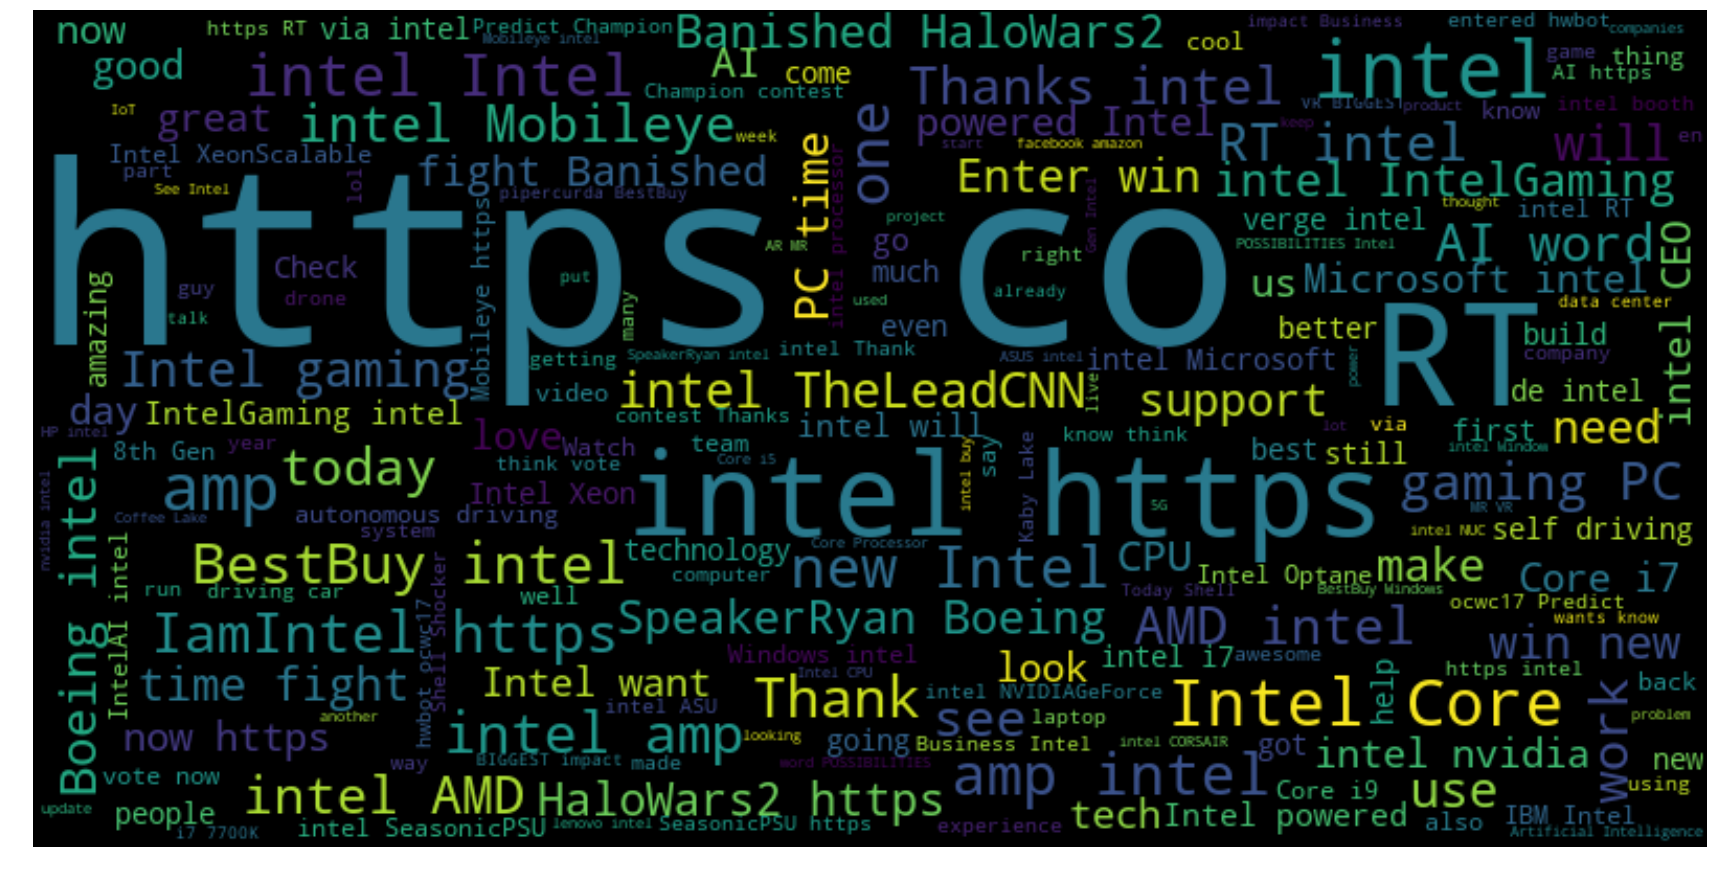

language: en,	number of tweets: 107998,	 percentage: 87%
language: es,	number of tweets: 3598,	 percentage: 3%
language: it,	number of tweets: 2611,	 percentage: 2%
language: de,	number of tweets: 1863,	 percentage: 2%
language: nl,	number of tweets: 1855,	 percentage: 2%
language: fr,	number of tweets: 1502,	 percentage: 1%
language: af,	number of tweets: 524,	 percentage: 0%
language: ca,	number of tweets: 522,	 percentage: 0%
language: pt,	number of tweets: 519,	 percentage: 0%
language: id,	number of tweets: 356,	 percentage: 0%
the top 10 frequncy word: 
('the', 37236)
('to', 31186)
('a', 21020)
('and', 19414)
('in', 17509)
('for', 16478)
('of', 15963)
('s', 15089)
('is', 13527)
('i', 13013)


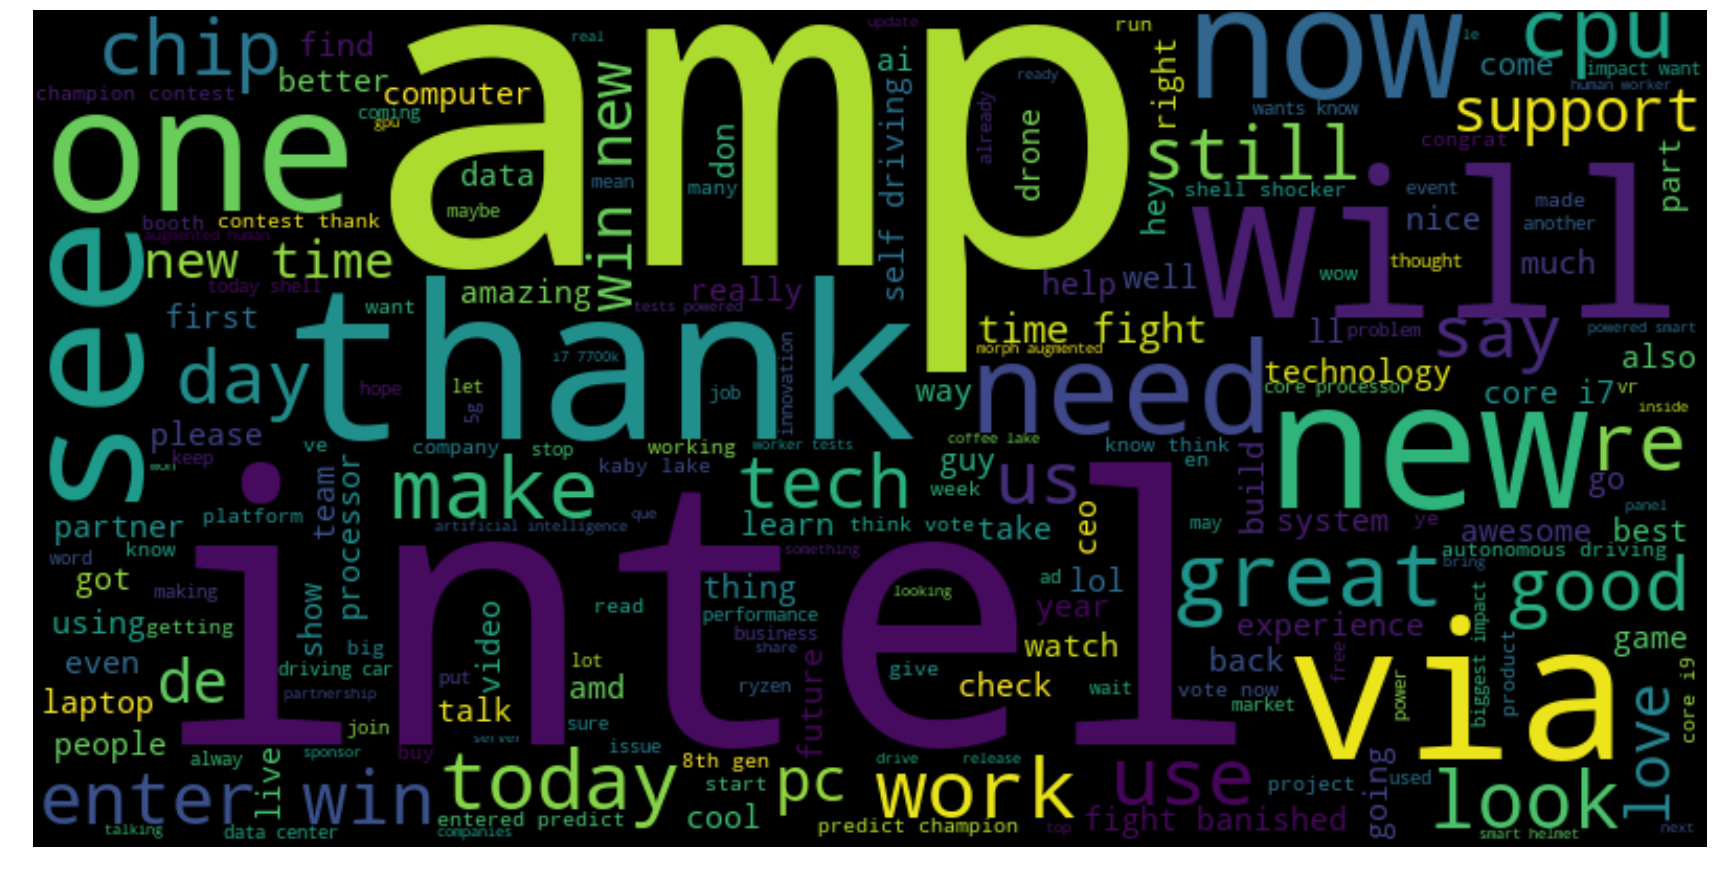

@Salesforce: 
nb tweets:
174649



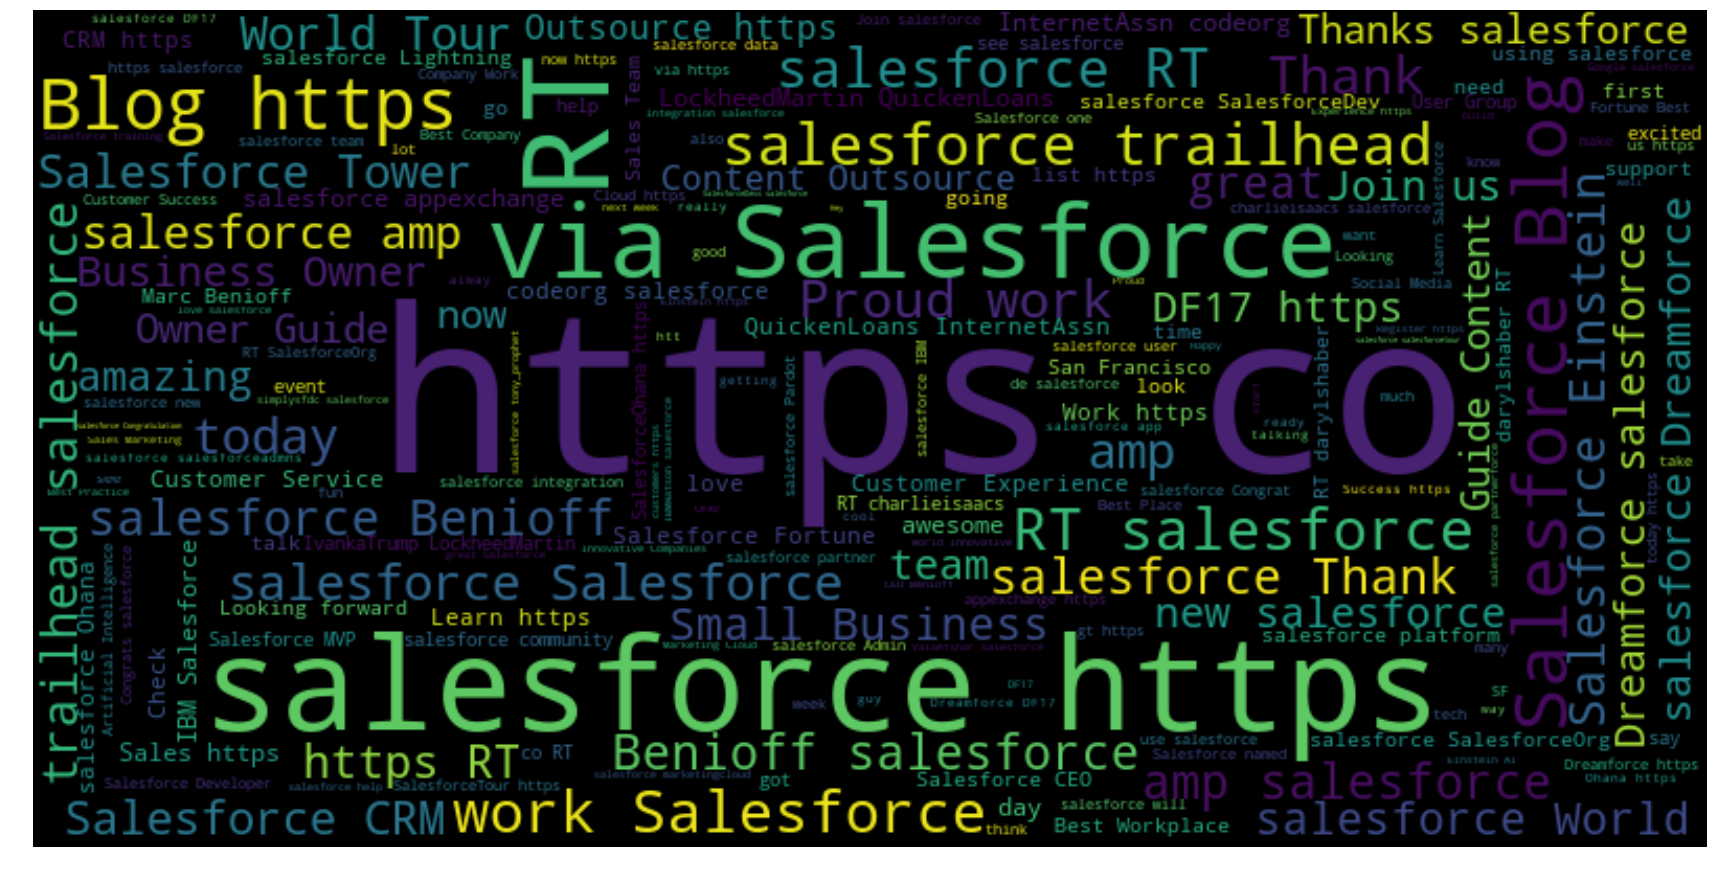

In [ ]:
for company in companies:
    print(company + ": ")
    tweets = get_tweets(company)
    print("nb tweets:")
    print(str(len(tweets)) + '\n')
    show_a_worldcloud(tweets)
    langs,lng = get_the_most_spoken_language(tweets)
    tweets = get_only_most_language_tweets(tweets, lng, langs)
    tweets = get_cleaned_data(tweets)
    tweets, dic = get_sorted_frequency_word(tweets)
    print("the top 10 frequncy word: ")
    for d in dic:
        print(d)
    worldcloud = show_and_get_a_better_worldcloud(tweets)
    
    
    